##### install Additional libraries

In [1]:
%%capture
!pip install tqdm --upgrade
!pip install keras-tuner --upgrade
!pip install awswrangler
!pip install--upgrade plotly
!pip install --upgrade seaborn
!pip install pydot
!pip install pydotplus
!pip install graphviz

##### Import libraries 

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
# Create a MirroredStrategy for multi gpu training
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [3]:
print(tf.__version__)

2.4.3


In [4]:
import numpy as np
import pandas as pd
from datetime import datetime, date, timedelta
import os
import math
import warnings 
import time
import boto3
from io import BytesIO
import re
import awswrangler as wr
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')
plt.style.use('seaborn')

import seaborn as sns
from IPython.display import Image
import pydot
import pydotplus
import graphviz

from tqdm import tqdm

## Using RNNs to classify sentiment on IMDB data

In this assignment,you will train three types of RNNs:  "vanilla" RNN, LSTM and GRU to predict the sentiment on IMDB reviews.  

Keras provides a convenient interface to load the data and immediately encode the words into integers (based on the most common words). 
This will save you a lot of the drudgery that is usually involved when working with raw text.

The IMDB is  data consists of 25000 training sequences and 25000 test sequences. 
The outcome is binary (positive/negative) and both outcomes are equally represented in both the training and the test set.


Walk through the followinng steps to prepare the data and the building of an RNN model. 

In [22]:
from tensorflow import keras
from tensorflow.keras import backend as k
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding,SimpleRNN,LSTM,Embedding, GlobalMaxPool1D, Dropout, Conv1D,LSTM, Flatten, GRU,Bidirectional
from tensorflow.keras.datasets import imdb
from tensorflow.keras import optimizers
from tensorflow.keras import initializers

1- Use the `imdb.load_data()` to load in the data 

2- Specify the maximum length of a sequence to 20000 words and the pick the most common words to 30. 

In [6]:
###### This is not correct should be the other way around  :
###### Specify the maximum length of a sequence to 20000 words and the pick the most common words to 30.
##### Should be: max length  = 30 and otherwise dimension will not match like describe below : Expected output:

# x_train shape: (25000, 30)
# x_test shape: (25000, 30)

##### max_features_words = 20000

In [7]:
import time
start_time = time.time()

max_features_words= 20000 ##### maximum length of a sequence
# cut texts after this number of words (among top max_features most common words)
maxlen= 30

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features_words)

print("--- %s seconds ---" % (time.time() - start_time))  

--- 4.514948129653931 seconds ---


In [8]:
print("Maximum value of a word index ")
print(max([max(sequence) for sequence in x_train]))
print("Maximum length num words of review in train ")
print(max([len(sequence) for sequence in x_train]))

Maximum value of a word index 
19999
Maximum length num words of review in train 
2494


In [9]:
from statistics import mean,median 

In [10]:

print("Mean length num words of review in train ")
print(mean([len(sequence) for sequence in x_train]))

Mean length num words of review in train 
238.71364


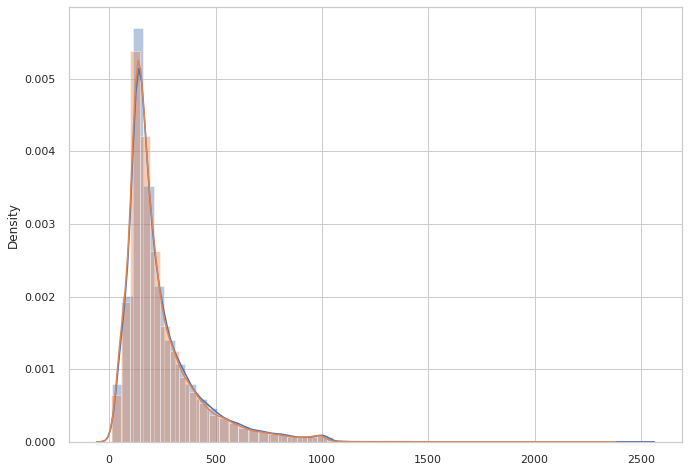

In [11]:
review_len_train = []
review_len_test = []
for i,ii in zip(x_train, x_test):
    review_len_train.append(len(i))
    review_len_test.append(len(ii))

sns.set(style="whitegrid")
plt.figure(figsize=(11,8))

sns.distplot(review_len_train)
sns.distplot(review_len_test)
plt.show()

In [12]:

print("Median  length num words of review in train ")
print(median ([len(sequence) for sequence in x_train]))

Median  length num words of review in train 
178.0


In [13]:
print("Y train values: ",np.unique(y_train))
print("Y test values: ",np.unique(y_test))

Y train values:  [0 1]
Y test values:  [0 1]


3- Check that the number of sequences in train and test datasets are equal (default split):
    
Expected output:
- `x_train = 25000 train sequences`

- `x_test = 25000 test sequences`

In [8]:
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

25000 train sequences
25000 test sequences


4- Pad (or truncate) the sequences so that they are of the maximum length

In [9]:
import time
start_time = time.time()

x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

print("--- %s seconds ---" % (time.time() - start_time))  

--- 0.3547811508178711 seconds ---


5- After padding or truncating, check the dimensionality of x_train and x_test.

Expected output:
- `x_train shape: (25000, 30)`
- `x_test shape: (25000, 30)`

In [10]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (25000, 30)
x_test shape: (25000, 30)


In [11]:
x_train[0]

array([  18,   51,   36,   28,  224,   92,   25,  104,    4,  226,   65,
         16,   38, 1334,   88,   12,   16,  283,    5,   16, 4472,  113,
        103,   32,   15,   16, 5345,   19,  178,   32], dtype=int32)

In [12]:
x_test[0]

array([   31,    23,    27,  7479,    29,   220,   468,     8,   124,
          14,   286,   170,     8,   157,    46,     5,    27,   239,
          16,   179, 15387,    38,    32,    25,  7944,   451,   202,
          14,     6,   717], dtype=int32)

In [13]:
y_train[0]

1

In [14]:
y_test[0]

0

## Keras layers for (Vanilla) RNNs

In this step, you will not use pre-trained word vectors, Instead you will learn an embedding as part of the  the Vanilla) RNNs network  Neural Network. 

In the Keras API documentation, the Embedding Layer and the SimpleRNN Layer have the following syntax:

### Embedding Layer
`keras.layers.embeddings.Embedding(input_dim, output_dim, embeddings_initializer='uniform', embeddings_regularizer=None, activity_regularizer=None, embeddings_constraint=None, mask_zero=False, input_length=None)`

- This layer maps each integer into a distinct (dense) word vector of length `output_dim`.
- Can think of this as learning a word vector embedding "on the fly" rather than using an existing mapping (like GloVe)
- The `input_dim` should be the size of the vocabulary.
- The `input_length` specifies the length of the sequences that the network expects.

### SimpleRNN Layer
`keras.layers.recurrent.SimpleRNN(units, activation='tanh', use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0, recurrent_dropout=0.0)`

- This is the basic RNN, where the output is also fed back as the "hidden state" to the next iteration.
- The parameter `units` gives the dimensionality of the output (and therefore the hidden state).  Note that typically there will be another layer after the RNN mapping the (RNN) output to the network output.  So we should think of this value as the desired dimensionality of the hidden state and not necessarily the desired output of the network.
- Recall that there are two sets of weights, one for the "recurrent" phase and the other for the "kernel" phase.  These can be configured separately in terms of their initialization, regularization, etc.






6- Build the RNN with three layers: 
- The SimpleRNN layer with 5 neurons and initialize its kernel with stddev=0.001

- The Embedding layer and initialize it by setting the word embedding dimension to 50. This means that this layer takes each integer in the sequence and embeds it in a 50-dimensional vector.

-  The output layer has the sigmoid activation function.

In [15]:
x_train.shape[1]

30

In [16]:
# embedding dimension = 50

In [17]:
tf.debugging.set_log_device_placement(True)
gpus = tf.config.list_logical_devices('GPU')
strategy = tf.distribute.MirroredStrategy(gpus)
with strategy.scope():
    def simple_rnn():
        model = Sequential()
        model.add(Embedding(max_features_words, 50, input_shape=(x_train.shape[1],))) 
        model.add(SimpleRNN(5,  kernel_initializer=initializers.RandomNormal(stddev=0.001)))
        model.add(Dense(1, activation='sigmoid')) ##### Dense 1 == output class
        model.summary()
        return model

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [20]:
model = simple_rnn()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 50)            1000000   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 5)                 280       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 1,000,286
Trainable params: 1,000,286
Non-trainable params: 0
_________________________________________________________________


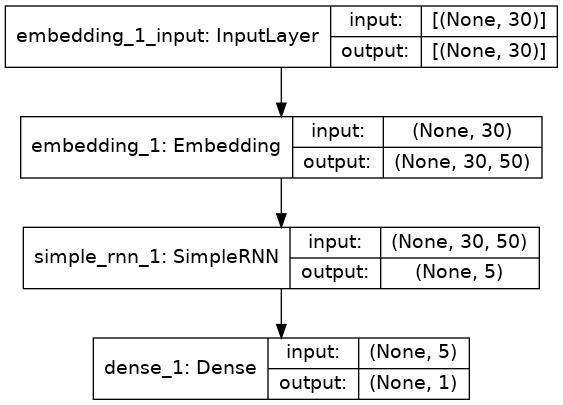

In [21]:
from tensorflow.keras.utils import plot_model
#plot the RNNlstm model architecture

plot_model(model, to_file='rnn_model_plot.png', show_shapes=True, show_layer_names=True)

7- How many parameters have the embedding layer?

In [22]:
#### Param  =  1000000 

8- Train the network with the RMSprop with learning rate of .0001 and epochs=10.

In [10]:
METRICS = [ 
      keras.metrics.BinaryAccuracy(name='acc'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall')
]

In [24]:
##### Compile model 

model.compile(optimizer = optimizers.RMSprop(lr = .0001), 
             loss='binary_crossentropy',
              metrics=METRICS )

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 50)            1000000   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 5)                 280       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 1,000,286
Trainable params: 1,000,286
Non-trainable params: 0
_________________________________________________________________


In [25]:
import time

start = time.time()

# train model
history = model.fit(x_train, y_train,
                    epochs=10,
                    validation_split=0.2)

end = time.time()

print(end - start)

Epoch 1/10
625/625 [==============================] - 10s 14ms/step - loss: 0.6851 - acc: 0.5549 - precision: 0.5485 - recall: 0.6822 - val_loss: 0.6183 - val_acc: 0.6664 - val_precision: 0.6477 - val_recall: 0.7112
Epoch 2/10
625/625 [==============================] - 8s 13ms/step - loss: 0.5902 - acc: 0.6946 - precision: 0.6934 - recall: 0.6990 - val_loss: 0.5667 - val_acc: 0.7144 - val_precision: 0.7068 - val_recall: 0.7205
Epoch 3/10
625/625 [==============================] - 9s 14ms/step - loss: 0.5287 - acc: 0.7550 - precision: 0.7585 - recall: 0.7506 - val_loss: 0.5358 - val_acc: 0.7372 - val_precision: 0.7318 - val_recall: 0.7384
Epoch 4/10
625/625 [==============================] - 8s 13ms/step - loss: 0.4880 - acc: 0.7799 - precision: 0.7791 - recall: 0.7776 - val_loss: 0.5158 - val_acc: 0.7506 - val_precision: 0.7460 - val_recall: 0.7505
Epoch 5/10
625/625 [==============================] - 8s 13ms/step - loss: 0.4557 - acc: 0.8010 - precision: 0.8049 - recall: 0.7948 - val_

9- PLot the loss and accuracy metrics during the training and interpret the result.

In [26]:
from pandas import option_context

with option_context('display.max_rows', 3000,'display.max_colwidth', 200,'display.max_columns',50):
              display(pd.DataFrame(model.history.history).head(10))

,loss,acc,precision,recall,val_loss,val_acc,val_precision,val_recall
0,0.665730,0.60490,0.596501,0.655967,0.618312,0.6664,0.647731,0.711219
1,0.577798,0.70525,0.705485,0.707806,0.566739,0.7144,0.706794,0.720535
2,0.522954,0.75675,0.759964,0.752766,0.535805,0.7372,0.731835,0.738356
3,0.484789,0.78270,0.785650,0.779384,0.515832,0.7506,0.745974,0.750506
4,0.454707,0.80150,0.805094,0.797229,0.502097,0.7552,0.767053,0.724180
5,0.429535,0.81665,0.821479,0.810587,0.492534,0.7636,0.753646,0.774403
6,0.409464,0.82685,0.830782,0.822251,0.484582,0.7698,0.757221,0.785743
7,0.391513,0.83645,0.841138,0.830824,0.480362,0.7714,0.767123,0.771162
8,0.376417,0.84360,0.849661,0.836108,0.480107,0.7716,0.765506,0.774808
9,0.362730,0.85160,0.856609,0.845678,0.479571,0.7724,0.775114,0.759417


In [27]:
def max_metric(model):
    max_acc = max(model.history.history['acc'])
    
    min_loss = min(model.history.history['loss'])
    max_val_acc = max(model.history.history['val_acc'])
    
    min_val_loss = min(model.history.history['val_loss'])
    print(f"Maximum Accuracy: {max_acc} \nMinimum categorical_crossentropy loss: {min_loss} \nMaximum Validation Accuracy: {max_val_acc} \nMaximum Validation categorical_crossentropy Loss: {min_val_loss} \n")


In [28]:
max_metric(model)

Maximum Accuracy: 0.8515999913215637 
Minimum categorical_crossentropy loss: 0.3627302646636963 
Maximum Validation Accuracy: 0.7724000215530396 
Maximum Validation categorical_crossentropy Loss: 0.4795711934566498 



In [36]:

print("Training Accuracy is: ",format(history.history['acc'][-1],".2f"))

Training Accuracy is:  0.85


In [37]:

print("Validation Accuracy is: ",format(history.history['val_acc'][-1],".2f"))

Validation Accuracy is:  0.77


In [38]:
print("Training loss is: ",format(history.history['loss'][-1],".2f"))

Training loss is:  0.36


In [39]:
print("Validation loss is: ",format(history.history['val_loss'][-1],".2f"))

Validation loss is:  0.48


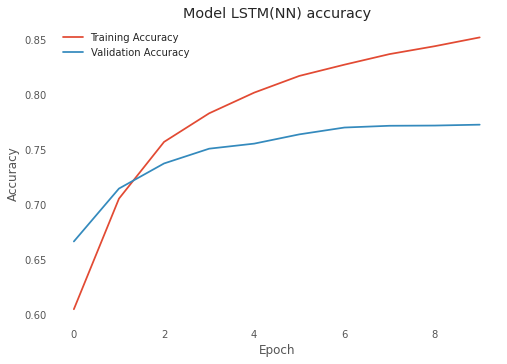

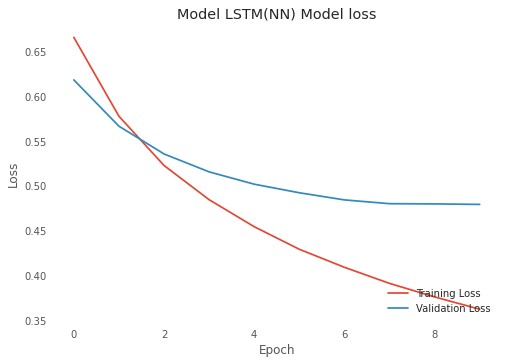

In [40]:

#### Plot training & validation accuracy values
figsize = (25, 12)
plt.style.use("ggplot")
plt.rcParams['axes.facecolor']='white'
plt.plot(model.history.history['acc'])
plt.plot(model.history.history['val_acc'])
plt.title('Model LSTM(NN) accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

#### Plot training & validation loss values
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model LSTM(NN) Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
plt.show()

###### Our simple RNN model achieved the following results in our training set:
###### accuracy = 0.85 ( 85 % )
###### loss = 0.36
###### In terms of training time I was able to set up GPU training runtime
###### total training time was : 87.266 sec
##### he training loss was decreasing are the number of epochs were increasing
##### We could train for more epochs based on the val accuracy line

10- Check the accuracy and the loss of your models on the test dataset.

In [41]:
score = model.evaluate(x_test,y_test)


782/782 [==============================] - 3s 4ms/step - loss: 0.4774 - acc: 0.7712 - precision: 0.7811 - recall: 0.7537


In [42]:
score

[0.4774017333984375,
 0.7712399959564209,
 0.7811126708984375,
 0.7536799907684326]

In [43]:
from pandas import option_context

with option_context('display.max_rows', 3000,'display.max_colwidth', 200,'display.max_columns',50):
              display(pd.DataFrame(score).head(20))

,0
0,0.477402
1,0.771240
2,0.781113
3,0.753680


In [44]:
score 

[0.4774017333984375,
 0.7712399959564209,
 0.7811126708984375,
 0.7536799907684326]

In [45]:
print("loss in test set:", score[0]*100)

loss in test set: 47.74017333984375


In [46]:
print("Accuracy IN test set:", score[1]*100)

Accuracy IN test set: 77.12399959564209


##### We obtained an accuracy = 77.12 in our test set

## Tuning The Vanilla RNN Network


11- Prepare the data to use sequences of length 80 rather than length 30 and retrain your model. Did it improve the performance?

In [47]:
import time
start_time = time.time()

x_train = sequence.pad_sequences(x_train, maxlen=80)
x_test = sequence.pad_sequences(x_test, maxlen=80)

print("--- %s seconds ---" % (time.time() - start_time)) 

--- 0.11217284202575684 seconds ---


In [48]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (25000, 80)
x_test shape: (25000, 80)


In [49]:
tf.debugging.set_log_device_placement(True)
gpus = tf.config.list_logical_devices('GPU')
strategy = tf.distribute.MirroredStrategy(gpus)
with strategy.scope():
    def simple_rnn2():
        model = Sequential()
        model.add(Embedding(max_features_words, 50, input_shape=(x_train.shape[1],))) 
        model.add(SimpleRNN(5,  kernel_initializer=initializers.RandomNormal(stddev=0.001)))
        model.add(Dense(1, activation='sigmoid')) ##### Dense 1 == output class
        model.summary()
        return model

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [50]:
model2 = simple_rnn2()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 80, 50)            1000000   
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 5)                 280       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 1,000,286
Trainable params: 1,000,286
Non-trainable params: 0
_________________________________________________________________


In [51]:
##### Compile model 

model2.compile(optimizer = optimizers.RMSprop(lr = .0001), 
             loss='binary_crossentropy',
              metrics=METRICS )

model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 80, 50)            1000000   
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 5)                 280       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 1,000,286
Trainable params: 1,000,286
Non-trainable params: 0
_________________________________________________________________


In [52]:
import time

start = time.time()

# train model
history1 = model2.fit(x_train, y_train,
                    epochs=10,
                    validation_split=0.2)

end = time.time()

print(end - start)

Epoch 1/10
625/625 [==============================] - 20s 31ms/step - loss: 0.6919 - acc: 0.7061 - precision: 0.6959 - recall: 0.7379 - val_loss: 0.6685 - val_acc: 0.6872 - val_precision: 0.7003 - val_recall: 0.6407
Epoch 2/10
625/625 [==============================] - 19s 31ms/step - loss: 0.6552 - acc: 0.6541 - precision: 0.6529 - recall: 0.6601 - val_loss: 0.6270 - val_acc: 0.6674 - val_precision: 0.6136 - val_recall: 0.8817
Epoch 3/10
625/625 [==============================] - 19s 30ms/step - loss: 0.6074 - acc: 0.7043 - precision: 0.7017 - recall: 0.7153 - val_loss: 0.5884 - val_acc: 0.7082 - val_precision: 0.6678 - val_recall: 0.8141
Epoch 4/10
625/625 [==============================] - 19s 30ms/step - loss: 0.5657 - acc: 0.7359 - precision: 0.7371 - recall: 0.7320 - val_loss: 0.5581 - val_acc: 0.7342 - val_precision: 0.7102 - val_recall: 0.7801
Epoch 5/10
625/625 [==============================] - 19s 30ms/step - loss: 0.5325 - acc: 0.7614 - precision: 0.7647 - recall: 0.7611 - 

In [53]:
print("Training Accuracy model2 is: ",format(history1.history['acc'][-1],".2f"))

Training Accuracy model2 is:  0.82


In [54]:
print("Validation Accuracy model2 is: ",format(history1.history['val_acc'][-1],".2f"))

Validation Accuracy model2 is:  0.77


In [55]:
print("Training loss model2 is: ",format(history1.history['loss'][-1],".2f"))

Training loss model2 is:  0.41


In [56]:
print("Validation loss model2 is: ",format(history1.history['val_loss'][-1],".2f"))

Validation loss model2 is:  0.47


In [57]:
score2 = model2.evaluate(x_test,y_test)


782/782 [==============================] - 6s 7ms/step - loss: 0.4635 - acc: 0.7838 - precision: 0.7808 - recall: 0.7890


In [58]:
print("loss in test set:", score2[0]*100)

loss in test set: 46.350690722465515


In [61]:
print("Accuracy in test set:", score2[1]*100)

Accuracy in test set: 78.37600111961365


##### Model2 with sequences of length 80 did improve our Accuracy in test set to 78.37 vs 77.12 (simple rnn maxlen=30)

12- Try different values of the maximum length of a sequence ("max_features"). Can you improve the performance?

In [ ]:
#### maxlen=150

In [62]:
import time
start_time = time.time()

x_train = sequence.pad_sequences(x_train, maxlen=150)
x_test = sequence.pad_sequences(x_test, maxlen=150)

print("--- %s seconds ---" % (time.time() - start_time)) 



print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)


--- 0.11661529541015625 seconds ---
x_train shape: (25000, 150)
x_test shape: (25000, 150)


In [63]:

tf.debugging.set_log_device_placement(True)
gpus = tf.config.list_logical_devices('GPU')
strategy = tf.distribute.MirroredStrategy(gpus)
with strategy.scope():
    def simple_rnn3():
        model = Sequential()
        model.add(Embedding(max_features_words, 50, input_shape=(x_train.shape[1],))) 
        model.add(SimpleRNN(5,  kernel_initializer=initializers.RandomNormal(stddev=0.001)))
        model.add(Dense(1, activation='sigmoid')) ##### Dense 1 == output class
        model.summary()
        return model


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [64]:
model3 = simple_rnn3()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 150, 50)           1000000   
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 5)                 280       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 1,000,286
Trainable params: 1,000,286
Non-trainable params: 0
_________________________________________________________________


In [65]:

##### Compile model 

model3.compile(optimizer = optimizers.RMSprop(lr = .0001), 
             loss='binary_crossentropy',
              metrics=METRICS )

model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 150, 50)           1000000   
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 5)                 280       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 1,000,286
Trainable params: 1,000,286
Non-trainable params: 0
_________________________________________________________________


In [66]:
import time

start = time.time()

# train model
history2 = model3.fit(x_train, y_train,
                    epochs=10,
                    validation_split=0.2)

end = time.time()

print(end - start)

Epoch 1/10
625/625 [==============================] - 35s 55ms/step - loss: 0.6931 - acc: 0.7106 - precision: 0.6813 - recall: 0.8078 - val_loss: 0.6929 - val_acc: 0.5178 - val_precision: 0.5163 - val_recall: 0.3726
Epoch 2/10
625/625 [==============================] - 34s 54ms/step - loss: 0.6919 - acc: 0.5563 - precision: 0.5588 - recall: 0.5892 - val_loss: 0.6922 - val_acc: 0.5228 - val_precision: 0.5198 - val_recall: 0.4419
Epoch 3/10
625/625 [==============================] - 34s 54ms/step - loss: 0.6877 - acc: 0.5795 - precision: 0.5786 - recall: 0.6087 - val_loss: 0.6917 - val_acc: 0.5198 - val_precision: 0.5295 - val_recall: 0.2471
Epoch 4/10
625/625 [==============================] - 34s 54ms/step - loss: 0.6792 - acc: 0.5948 - precision: 0.6075 - recall: 0.5331 - val_loss: 0.6912 - val_acc: 0.5264 - val_precision: 0.5184 - val_recall: 0.5751
Epoch 5/10
625/625 [==============================] - 34s 55ms/step - loss: 0.6688 - acc: 0.6189 - precision: 0.6175 - recall: 0.6382 - 

In [67]:

print("Training Accuracy model3 is: ",format(history2.history['acc'][-1],".2f"))



print("Validation Accuracy model3 is: ",format(history2.history['val_acc'][-1],".2f"))




print("Training loss model3 is: ",format(history2.history['loss'][-1],".2f"))




print("Validation loss model3 is: ",format(history2.history['val_loss'][-1],".2f"))


Training Accuracy model3 is:  0.70
Validation Accuracy model3 is:  0.53
Training loss model3 is:  0.60
Validation loss model3 is:  0.70


In [69]:

score3 = model3.evaluate(x_test,y_test)

782/782 [==============================] - 9s 11ms/step - loss: 0.7053 - acc: 0.5285 - precision: 0.5367 - recall: 0.4170


In [71]:
print("loss in test set:", score3[0]*100)


print("Accuracy in test set:", score3[1]*100)

loss in test set: 70.5255925655365
Accuracy in test set: 52.851998805999756


##### Model3 with sequences of length 150 did not improve our Accuracy in test set as we can observed above vs first two models 78.37 vs 77.12
##### training time also increased to : 341.21 sec because of the max len of the reviews

###### maxlen= 500

In [94]:
import time
start_time = time.time()

x_train = sequence.pad_sequences(x_train, maxlen=500)
x_test = sequence.pad_sequences(x_test, maxlen=500)

print("--- %s seconds ---" % (time.time() - start_time)) 

--- 0.9704670906066895 seconds ---


In [95]:

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)


x_train shape: (25000, 500)
x_test shape: (25000, 500)


In [96]:
tf.debugging.set_log_device_placement(True)
gpus = tf.config.list_logical_devices('GPU')
strategy = tf.distribute.MirroredStrategy(gpus)
with strategy.scope():
    def simple_rnn4():
        model = Sequential()
        model.add(Embedding(max_features_words, 50, input_shape=(x_train.shape[1],))) 
        model.add(SimpleRNN(5,  kernel_initializer=initializers.RandomNormal(stddev=0.001)))
        model.add(Dense(1, activation='sigmoid')) ##### Dense 1 == output class
        model.summary()
        return model
    
model4 = simple_rnn4()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 50)           1000000   
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 5)                 280       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 6         
Total params: 1,000,286
Trainable params: 1,000,286
Non-trainable params: 0
_________________________________________________________________


In [98]:
##### Compile model 

model4.compile(optimizer = optimizers.RMSprop(lr = .0001), 
             loss='binary_crossentropy',
              metrics=METRICS )

model4.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 50)           1000000   
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 5)                 280       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 6         
Total params: 1,000,286
Trainable params: 1,000,286
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import time

start = time.time()

# train model
history4 = model4.fit(x_train, y_train,
                    epochs=10,
                    validation_split=0.2)

end = time.time()

print(end - start)

Epoch 1/10
625/625 [==============================] - 113s 180ms/step - loss: 0.6932 - acc: 0.5203 - precision: 0.5252 - recall: 0.4311 - val_loss: 0.6933 - val_acc: 0.4942 - val_precision: 0.4897 - val_recall: 0.5804
Epoch 2/10
625/625 [==============================] - 112s 179ms/step - loss: 0.6894 - acc: 0.5562 - precision: 0.5651 - recall: 0.4789 - val_loss: 0.6954 - val_acc: 0.4958 - val_precision: 0.4923 - val_recall: 0.6768
Epoch 3/10
625/625 [==============================] - 112s 179ms/step - loss: 0.6771 - acc: 0.5911 - precision: 0.5904 - recall: 0.6375 - val_loss: 0.7040 - val_acc: 0.5040 - val_precision: 0.4931 - val_recall: 0.1600
Epoch 4/10
625/625 [==============================] - 112s 180ms/step - loss: 0.6586 - acc: 0.6386 - precision: 0.6501 - recall: 0.6032 - val_loss: 0.7026 - val_acc: 0.4904 - val_precision: 0.4700 - val_recall: 0.2503
Epoch 5/10
625/625 [==============================] - 112s 179ms/step - loss: 0.6387 - acc: 0.6864 - precision: 0.6917 - recall:

In [ ]:
##### evaluation training / test set results model maxlenght = 500

In [100]:

print("Training Accuracy model4 is: ",format(history4.history['acc'][-1],".2f"))




print("Validation Accuracy model4 is: ",format(history4.history['val_acc'][-1],".2f"))





print("Training loss model4 is: ",format(history4.history['loss'][-1],".2f"))





print("Validation loss model4 is: ",format(history4.history['val_loss'][-1],".2f"))





score4 = model4.evaluate(x_test,y_test)




print("loss in test set:", score4[0]*100)




print("Accuracy in test set:", score4[1]*100)

Training Accuracy model4 is:  0.80
Validation Accuracy model4 is:  0.50
Training loss model4 is:  0.55
Validation loss model4 is:  0.72
782/782 [==============================] - 25s 32ms/step - loss: 0.7157 - acc: 0.5063 - precision: 0.5044 - recall: 0.7326
loss in test set: 71.56530618667603
Accuracy in test set: 50.63199996948242


###### Model4 with sequences of length 500 did not improve our Accuracy in test set as we can observed above (test acc =50.63) vs first two models 78.37 vs 77.12

###### training time also increased to : 1121.79 sec because of the max len of the reviews

13- Try smaller and larger sizes of the RNN hidden dimension. How does it affect the model performance? How does it affect the run time?

###### larger size of the RNN hidden dimension and maxlen=80

##### RNN hidden = 16

In [20]:
import time
start_time = time.time()

x_train = sequence.pad_sequences(x_train, maxlen=80)
x_test = sequence.pad_sequences(x_test, maxlen=80)

print("--- %s seconds ---" % (time.time() - start_time)) 

--- 0.11385774612426758 seconds ---


In [21]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (25000, 80)
x_test shape: (25000, 80)


In [22]:
tf.debugging.set_log_device_placement(True)
gpus = tf.config.list_logical_devices('GPU')
strategy = tf.distribute.MirroredStrategy(gpus)
with strategy.scope():
    def simple_rnn_larger16():
        model = Sequential()
        model.add(Embedding(max_features_words, 50, input_shape=(x_train.shape[1],))) 
        model.add(SimpleRNN(16,  kernel_initializer=initializers.RandomNormal(stddev=0.001)))
        model.add(Dense(1, activation='sigmoid')) ##### Dense 1 == output class
        model.summary()
        return model


# In[50]:


model5 = simple_rnn_larger16()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 80, 50)            1000000   
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 16)                1072      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 1,001,089
Trainable params: 1,001,089
Non-trainable params: 0
_________________________________________________________________


In [23]:
##### Compile model rnn_larger16

model5.compile(optimizer = optimizers.RMSprop(lr = .0001), 
             loss='binary_crossentropy',
              metrics=METRICS )

model5.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 80, 50)            1000000   
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 16)                1072      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 1,001,089
Trainable params: 1,001,089
Non-trainable params: 0
_________________________________________________________________


In [24]:

import time

start = time.time()

# train model
history5 = model5.fit(x_train, y_train,
                    epochs=10,
                    validation_split=0.2)

end = time.time()

print(end - start)


Epoch 1/10
625/625 [==============================] - 21s 32ms/step - loss: 0.6866 - acc: 0.5296 - precision: 0.5249 - recall: 0.7422 - val_loss: 0.6311 - val_acc: 0.6598 - val_precision: 0.6074 - val_recall: 0.8793
Epoch 2/10
625/625 [==============================] - 19s 31ms/step - loss: 0.5876 - acc: 0.7128 - precision: 0.7115 - recall: 0.7155 - val_loss: 0.5507 - val_acc: 0.7338 - val_precision: 0.7979 - val_recall: 0.6173
Epoch 3/10
625/625 [==============================] - 19s 31ms/step - loss: 0.4980 - acc: 0.7897 - precision: 0.7897 - recall: 0.7932 - val_loss: 0.4872 - val_acc: 0.7822 - val_precision: 0.8050 - val_recall: 0.7375
Epoch 4/10
625/625 [==============================] - 20s 32ms/step - loss: 0.4363 - acc: 0.8231 - precision: 0.8246 - recall: 0.8203 - val_loss: 0.4413 - val_acc: 0.8072 - val_precision: 0.8038 - val_recall: 0.8064
Epoch 5/10
625/625 [==============================] - 19s 31ms/step - loss: 0.3740 - acc: 0.8552 - precision: 0.8556 - recall: 0.8574 - 

In [25]:
from pandas import option_context

with option_context('display.max_rows', 3000,'display.max_colwidth', 200,'display.max_columns',50):
              display(pd.DataFrame(model5.history.history).head(20))

,loss,acc,precision,recall,val_loss,val_acc,val_precision,val_recall
0,0.667873,0.58435,0.569532,0.701426,0.631086,0.6598,0.607443,0.879303
1,0.569608,0.72820,0.724650,0.738810,0.550730,0.7338,0.797906,0.617254
2,0.488974,0.79380,0.791186,0.800020,0.487240,0.7822,0.805040,0.737546
3,0.426806,0.82795,0.828974,0.827734,0.441279,0.8072,0.803795,0.806399
4,0.373222,0.85290,0.852511,0.854551,0.428867,0.8080,0.824516,0.776428
5,0.334622,0.86870,0.867713,0.871000,0.410244,0.8176,0.789728,0.859457
6,0.306946,0.87975,0.880159,0.880072,0.425624,0.8162,0.813005,0.815310
7,0.285178,0.88960,0.889553,0.890440,0.400804,0.8222,0.835030,0.797489
8,0.269240,0.89730,0.898571,0.896421,0.393778,0.8296,0.825614,0.830296
9,0.255432,0.90300,0.903944,0.902502,0.390172,0.8288,0.809359,0.854597


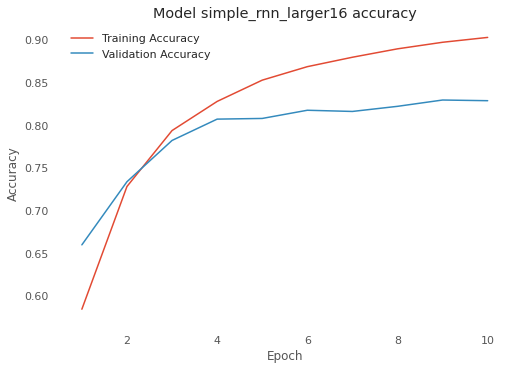

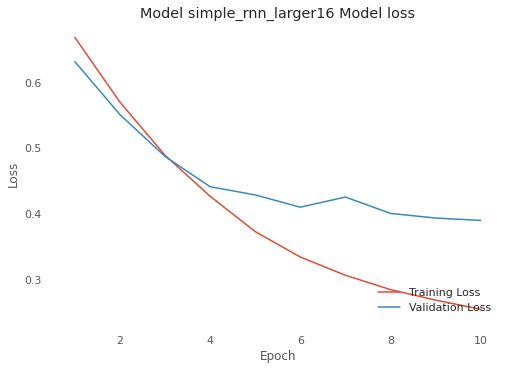

In [26]:

#### Plot training & validation accuracy values
figsize = (25, 12)
plt.style.use("ggplot")
plt.rcParams['axes.facecolor']='white'
epochs = range(1, (len(model5.history.history['acc']) + 1))
plt.plot(epochs,model5.history.history['acc'])
plt.plot(epochs,model5.history.history['val_acc'])
plt.title('Model simple_rnn_larger16 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

#### Plot training & validation loss values
plt.plot(epochs,model5.history.history['loss'])
plt.plot(epochs,model5.history.history['val_loss'])
plt.title('Model simple_rnn_larger16 Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
plt.show()

##### In terms of training time it almost double in comparision with first simple rnn  5 neurons
##### total training time was :195.73 sec

In [27]:
##### evaluation training / test set results model SimpleRNN(16)

In [28]:

print("Training Accuracy modelSimpleRNN(16) is: ",format(history5.history['acc'][-1],".2f"))




print("Validation Accuracy modelSimpleRNN(16)is: ",format(history5.history['val_acc'][-1],".2f"))





print("Training loss modelSimpleRNN(16)is: ",format(history5.history['loss'][-1],".2f"))





print("Validation loss modelSimpleRNN(16)is: ",format(history5.history['val_loss'][-1],".2f"))





score5 = model5.evaluate(x_test,y_test)




print("loss in test set:", score5[0]*100)




print("Accuracy in test set:", score5[1]*100)

Training Accuracy modelSimpleRNN(16) is:  0.90
Validation Accuracy modelSimpleRNN(16)is:  0.83
Training loss modelSimpleRNN(16)is:  0.26
Validation loss modelSimpleRNN(16)is:  0.39
782/782 [==============================] - 6s 7ms/step - loss: 0.3989 - acc: 0.8250 - precision: 0.8124 - recall: 0.8452
loss in test set: 39.8936003446579
Accuracy in test set: 82.4999988079071


###### Model5 SimpleRNN(16) with sequences of length 80 did improve our Accuracy in test set to 82.49 first two models 78.37 vs 77.12 (SimpleRNN layer with 5 neuron
###### Training time increased

######  smaller size of the RNN hidden dimension.

##### RNN hidden = 3

In [113]:
import time
start_time = time.time()

x_train = sequence.pad_sequences(x_train, maxlen=80)
x_test = sequence.pad_sequences(x_test, maxlen=80)

print("--- %s seconds ---" % (time.time() - start_time)) 

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)


--- 0.11701583862304688 seconds ---
x_train shape: (25000, 80)
x_test shape: (25000, 80)


In [114]:
tf.debugging.set_log_device_placement(True)
gpus = tf.config.list_logical_devices('GPU')
strategy = tf.distribute.MirroredStrategy(gpus)
with strategy.scope():
    def simple_rnn_smaller3():
        model = Sequential()
        model.add(Embedding(max_features_words, 50, input_shape=(x_train.shape[1],))) 
        model.add(SimpleRNN(3,  kernel_initializer=initializers.RandomNormal(stddev=0.001)))
        model.add(Dense(1, activation='sigmoid')) ##### Dense 1 == output class
        model.summary()
        return model



model6 = simple_rnn_smaller3()


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 80, 50)            1000000   
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 3)                 162       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 4         
Total params: 1,000,166
Trainable params: 1,000,166
Non-trainable params: 0
_________________________________________________________________


In [115]:
##### Compile model simple_rnn_smaller3

model6.compile(optimizer = optimizers.RMSprop(lr = .0001), 
             loss='binary_crossentropy',
              metrics=METRICS )

model6.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 80, 50)            1000000   
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 3)                 162       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 4         
Total params: 1,000,166
Trainable params: 1,000,166
Non-trainable params: 0
_________________________________________________________________


In [116]:
import time

start = time.time()

# train model
history6 = model6.fit(x_train, y_train,
                    epochs=10,
                    validation_split=0.2)

end = time.time()

print(end - start)

Epoch 1/10
625/625 [==============================] - 20s 31ms/step - loss: 0.6703 - acc: 0.7689 - precision: 0.7557 - recall: 0.7954 - val_loss: 0.6006 - val_acc: 0.7032 - val_precision: 0.6556 - val_recall: 0.8404
Epoch 2/10
625/625 [==============================] - 20s 31ms/step - loss: 0.5687 - acc: 0.7481 - precision: 0.7432 - recall: 0.7490 - val_loss: 0.5616 - val_acc: 0.7512 - val_precision: 0.7667 - val_recall: 0.7132
Epoch 3/10
625/625 [==============================] - 19s 31ms/step - loss: 0.5339 - acc: 0.7847 - precision: 0.7787 - recall: 0.7947 - val_loss: 0.5433 - val_acc: 0.7626 - val_precision: 0.7367 - val_recall: 0.8080
Epoch 4/10
625/625 [==============================] - 19s 31ms/step - loss: 0.5070 - acc: 0.8075 - precision: 0.8036 - recall: 0.8156 - val_loss: 0.5264 - val_acc: 0.7764 - val_precision: 0.7946 - val_recall: 0.7380
Epoch 5/10
625/625 [==============================] - 19s 30ms/step - loss: 0.4856 - acc: 0.8245 - precision: 0.8254 - recall: 0.8190 - 

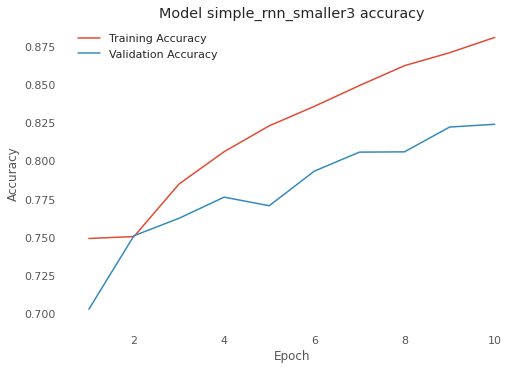

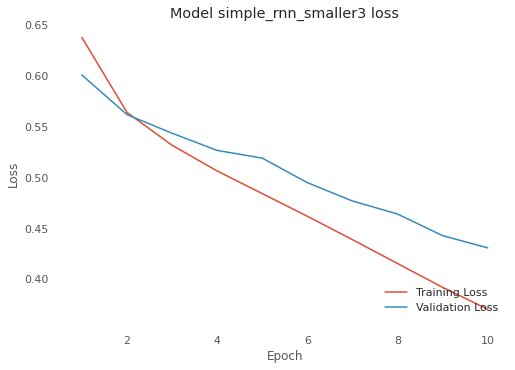

In [118]:

#### Plot training & validation accuracy values
figsize = (25, 12)
plt.style.use("ggplot")
plt.rcParams['axes.facecolor']='white'
epochs = range(1, (len(model6.history.history['acc']) + 1))
plt.plot(epochs,model6.history.history['acc'])
plt.plot(epochs,model6.history.history['val_acc'])
plt.title('Model simple_rnn_smaller3 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

#### Plot training & validation loss values
plt.plot(epochs,model6.history.history['loss'])
plt.plot(epochs,model6.history.history['val_loss'])
plt.title('Model simple_rnn_smaller3 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
plt.show()

In [120]:
##### In terms of training time it was similar to the previous rnn 16 but 
##### total training time was :192.84 sec

In [ ]:
##### evaluation training / test set results model SimpleRNN(3)

In [121]:

print("Training Accuracy modelSimpleRNN(3) is: ",format(history6.history['acc'][-1],".2f"))




print("Validation Accuracy modelSimpleRNN(3)is: ",format(history6.history['val_acc'][-1],".2f"))





print("Training loss modelSimpleRNN(3)is: ",format(history6.history['loss'][-1],".2f"))





print("Validation loss modelSimpleRNN(3)is: ",format(history6.history['val_loss'][-1],".2f"))





score6 = model6.evaluate(x_test,y_test)




print("loss in test set:", score6[0]*100)




print("Accuracy in test set:", score6[1]*100)

Training Accuracy modelSimpleRNN(3) is:  0.88
Validation Accuracy modelSimpleRNN(3)is:  0.82
Training loss modelSimpleRNN(3)is:  0.37
Validation loss modelSimpleRNN(3)is:  0.43
782/782 [==============================] - 6s 7ms/step - loss: 0.4441 - acc: 0.8099 - precision: 0.8002 - recall: 0.8261
loss in test set: 44.41485404968262
Accuracy in test set: 80.9880018234253


###### Model6 SimpleRNN(3) with sequences of length 80 did improve our Accuracy in test set to 80.98  vs first two models 78.37 vs 77.12 (SimpleRNN layer with 5 neuron)
###### But not improve it over our previous model of 16 hidden dimension. ( acc=82.49)
###### Training time increased compared with the previous two model

## Train LSTM and GRU networks


14- Build LSTM and GRU networks and compare their performance (accuracy and execution time) with the SimpleRNN. What is your conclusion?

##### LSTM Model with sequences of max length 80

In [11]:
import time
start_time = time.time()

x_train = sequence.pad_sequences(x_train, maxlen=80)
x_test = sequence.pad_sequences(x_test, maxlen=80)

print("--- %s seconds ---" % (time.time() - start_time)) 

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

--- 0.5105278491973877 seconds ---
x_train shape: (25000, 80)
x_test shape: (25000, 80)


#### LSTM model

In [18]:
tf.debugging.set_log_device_placement(True)
gpus = tf.config.list_logical_devices('GPU')
strategy = tf.distribute.MirroredStrategy(gpus)
with strategy.scope():
    def LSTM_100():
        model = Sequential()
        model.add(Embedding(max_features_words, 50, input_shape=(x_train.shape[1],))) 
        model.add(LSTM(units=100,return_sequences=True))
        model.add(LSTM(units=10))
        model.add(Dropout(0.5))
        model.add(Dense(8))
        model.add(Dense(1, activation='sigmoid')) ##### Dense 1 == output class
        model.summary()
        return model



model7 = LSTM_100()


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 80, 50)            1000000   
_________________________________________________________________
lstm_8 (LSTM)                (None, 80, 100)           60400     
_________________________________________________________________
lstm_9 (LSTM)                (None, 10)                4440      
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 88        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 1,06

In [21]:
##### Compile model LSTM_100

model7.compile(optimizer = optimizers.RMSprop(lr = .0001), 
             loss='binary_crossentropy',
              metrics=METRICS )

model7.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 80, 50)            1000000   
_________________________________________________________________
lstm_8 (LSTM)                (None, 80, 100)           60400     
_________________________________________________________________
lstm_9 (LSTM)                (None, 10)                4440      
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 88        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 1,064,937
Trainable params: 1,064,937
Non-trainable params: 0
____________________________________________

In [22]:
import time

start = time.time()

# train model
history7 = model7.fit(x_train, y_train,
                    epochs=10,
                    validation_split=0.2)

end = time.time()

print(end - start)

Epoch 1/10
625/625 [==============================] - 71s 15ms/step - loss: 0.6842 - acc: 0.5527 - precision: 0.5518 - recall: 0.5364 - val_loss: 0.5720 - val_acc: 0.7258 - val_precision: 0.7284 - val_recall: 0.7092
Epoch 2/10
625/625 [==============================] - 8s 13ms/step - loss: 0.5306 - acc: 0.7716 - precision: 0.7775 - recall: 0.7656 - val_loss: 0.4383 - val_acc: 0.8028 - val_precision: 0.8053 - val_recall: 0.7922
Epoch 3/10
625/625 [==============================] - 8s 13ms/step - loss: 0.4069 - acc: 0.8344 - precision: 0.8335 - recall: 0.8305 - val_loss: 0.4267 - val_acc: 0.8104 - val_precision: 0.8579 - val_recall: 0.7384
Epoch 4/10
625/625 [==============================] - 8s 13ms/step - loss: 0.3430 - acc: 0.8665 - precision: 0.8661 - recall: 0.8709 - val_loss: 0.3767 - val_acc: 0.8312 - val_precision: 0.8430 - val_recall: 0.8088
Epoch 5/10
625/625 [==============================] - 8s 13ms/step - loss: 0.3060 - acc: 0.8821 - precision: 0.8833 - recall: 0.8821 - val_

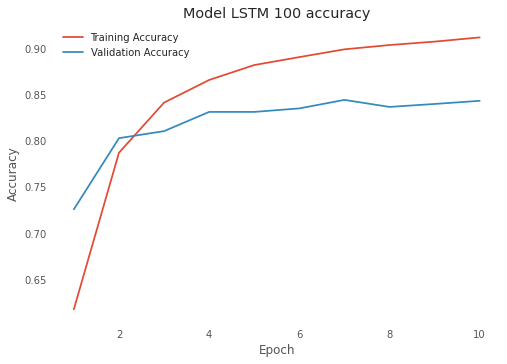

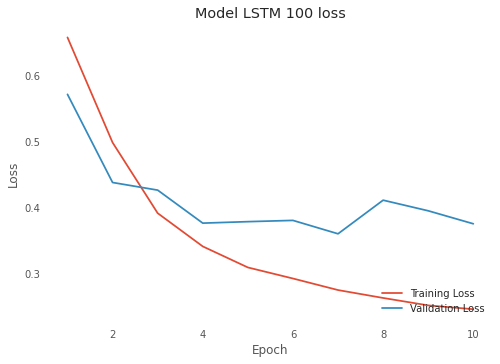

In [23]:
#### Plot training & validation accuracy values
figsize = (25, 12)
plt.style.use("ggplot")
plt.rcParams['axes.facecolor']='white'
epochs = range(1, (len(model7.history.history['acc']) + 1))
plt.plot(epochs,model7.history.history['acc'])
plt.plot(epochs,model7.history.history['val_acc'])
plt.title('Model LSTM 100 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

#### Plot training & validation loss values
plt.plot(epochs,model7.history.history['loss'])
plt.plot(epochs,model7.history.history['val_loss'])
plt.title('Model LSTM 100 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
plt.show()

##### In terms of training time it was similar to the previous rnn with 16 hidden units 
##### but greater than the firstSimpleRNN layer with 5 neurons  
##### total training time was :141.97 sec

In [24]:
##### evaluation training / test set results of LSTM model 100 

In [25]:

print("Training Accuracy LSTM 100 is: ",format(history7.history['acc'][-1],".2f"))




print("Validation Accuracy LSTM 100is: ",format(history7.history['val_acc'][-1],".2f"))





print("Training loss LSTM 100is: ",format(history7.history['loss'][-1],".2f"))





print("Validation loss LSTM 100is: ",format(history7.history['val_loss'][-1],".2f"))





score7 = model7.evaluate(x_test,y_test)




print("loss in test set:", score7[0]*100)




print("Accuracy in test set:", score7[1]*100)

Training Accuracy LSTM 100 is:  0.91
Validation Accuracy LSTM 100is:  0.84
Training loss LSTM 100is:  0.25
Validation loss LSTM 100is:  0.38
782/782 [==============================] - 4s 5ms/step - loss: 0.3909 - acc: 0.8382 - precision: 0.8507 - recall: 0.8202
loss in test set: 39.090582728385925
Accuracy in test set: 83.815997838974


##### LSTM Model with sequences of length 80 did improve our Accuracy in test set to 83.81 outperforming all previous models
#### Training time increased compared with the initial RNN models of with 5 neurons and max lenght 30

##### Let's change the optimizer to Adam and reduce the batch size to 32

In [13]:
tf.debugging.set_log_device_placement(True)
gpus = tf.config.list_logical_devices('GPU')
strategy = tf.distribute.MirroredStrategy(gpus)
with strategy.scope():
    def LSTM_100Adam():
        model = Sequential()
        model.add(Embedding(max_features_words, 50, input_shape=(x_train.shape[1],))) 
        model.add(LSTM(units=100,return_sequences=True))
        model.add(LSTM(units=10))
        model.add(Dropout(0.5))
        model.add(Dense(8))
        model.add(Dense(1, activation='sigmoid')) ##### Dense 1 == output class
        model.summary()
        return model



model8 = LSTM_100Adam()


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 80, 50)            1000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 80, 100)           60400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 10)                4440      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 88        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 1,06

In [14]:
##### Compile model LSTM_100

model8.compile(optimizer = optimizers.Adam(lr =  0.001, decay = 0.01/32), 
             loss='binary_crossentropy',
              metrics=METRICS )

model8.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 80, 50)            1000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 80, 100)           60400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 10)                4440      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 88        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 1,064,937
Trainable params: 1,064,937
Non-trainable params: 0
____________________________________________

In [15]:
import time

start = time.time()

# train model
history8 = model8.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

end = time.time()

print(end - start)

Epoch 1/10
625/625 [==============================] - 14s 17ms/step - loss: 0.5515 - acc: 0.6965 - precision: 0.6954 - recall: 0.6860 - val_loss: 0.3707 - val_acc: 0.8370 - val_precision: 0.8769 - val_recall: 0.7793
Epoch 2/10
625/625 [==============================] - 9s 15ms/step - loss: 0.2775 - acc: 0.9008 - precision: 0.9080 - recall: 0.8918 - val_loss: 0.3721 - val_acc: 0.8316 - val_precision: 0.8402 - val_recall: 0.8137
Epoch 3/10
625/625 [==============================] - 9s 15ms/step - loss: 0.1661 - acc: 0.9512 - precision: 0.9517 - recall: 0.9521 - val_loss: 0.4423 - val_acc: 0.8324 - val_precision: 0.8303 - val_recall: 0.8303
Epoch 4/10
625/625 [==============================] - 9s 15ms/step - loss: 0.1012 - acc: 0.9715 - precision: 0.9731 - recall: 0.9705 - val_loss: 0.5674 - val_acc: 0.8192 - val_precision: 0.8025 - val_recall: 0.8408
Epoch 5/10
625/625 [==============================] - 9s 15ms/step - loss: 0.0532 - acc: 0.9867 - precision: 0.9877 - recall: 0.9859 - val_

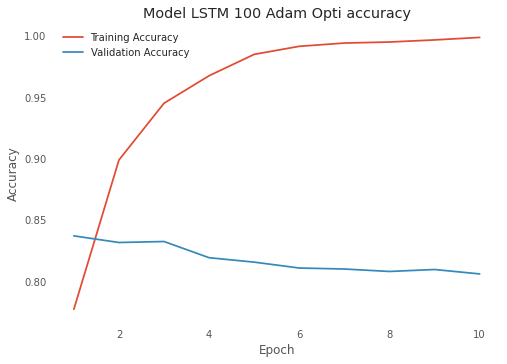

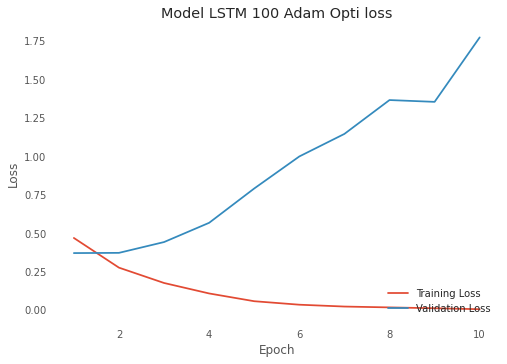

In [16]:
#### Plot training & validation accuracy values
figsize = (25, 12)
plt.style.use("ggplot")
plt.rcParams['axes.facecolor']='white'
epochs = range(1, (len(model8.history.history['acc']) + 1))
plt.plot(epochs,model8.history.history['acc'])
plt.plot(epochs,model8.history.history['val_acc'])
plt.title('Model LSTM 100 Adam Opti accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

#### Plot training & validation loss values
plt.plot(epochs,model8.history.history['loss'])
plt.plot(epochs,model8.history.history['val_loss'])
plt.title('Model LSTM 100 Adam Opti loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
plt.show()

In [17]:
print("Training Accuracy LSTM 100 Adam Opt is: ",format(history8.history['acc'][-1],".2f"))




print("Validation Accuracy LSTM 100 Adam Opt is: ",format(history8.history['val_acc'][-1],".2f"))





print("Training loss LSTM 100 Adam Opt is: ",format(history8.history['loss'][-1],".2f"))





print("Validation loss LSTM 100 Adam Opt is: ",format(history8.history['val_loss'][-1],".2f"))





score8 = model8.evaluate(x_test,y_test)




print("loss in test set:", score8[0]*100)




print("Accuracy in test set:", score8[1]*100)

Training Accuracy LSTM 100 Adam Opt is:  1.00
Validation Accuracy LSTM 100 Adam Opt is:  0.81
Training loss LSTM 100 Adam Opt is:  0.01
Validation loss LSTM 100 Adam Opt is:  1.77
782/782 [==============================] - 4s 5ms/step - loss: 1.8036 - acc: 0.8015 - precision: 0.8202 - recall: 0.7723
loss in test set: 180.36174774169922
Accuracy in test set: 80.15199899673462


In [18]:
##### Did not improve using RMSprop(lr = .0001) optimizer

###### GRU Layer with sequences of max length 80

In [23]:
tf.debugging.set_log_device_placement(True)
gpus = tf.config.list_logical_devices('GPU')
strategy = tf.distribute.MirroredStrategy(gpus)
with strategy.scope():
    def GRU_128():
        model = Sequential()
        model.add(Embedding(max_features_words, 50, input_shape=(x_train.shape[1],))) 
        model.add(GRU(128, return_sequences=False))
        model.add(Dropout(0.5))
        model.add(Dense(1, activation='sigmoid')) ##### Dense 1 == output class
        model.summary()
        return model



model9 = GRU_128()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 80, 50)            1000000   
_________________________________________________________________
gru (GRU)                    (None, 128)               69120     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 1,069,249
Trainable params: 1,069,249
Non-trainable params: 0
_________________________________________________________________


In [24]:
##### Compile model GRU

model9.compile(optimizer = optimizers.RMSprop(lr = .0001), 
             loss='binary_crossentropy',
              metrics=METRICS )

model9.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 80, 50)            1000000   
_________________________________________________________________
gru (GRU)                    (None, 128)               69120     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 1,069,249
Trainable params: 1,069,249
Non-trainable params: 0
_________________________________________________________________


In [25]:
##### Train GRU model

In [26]:
import time

start = time.time()

# train model
history9 = model9.fit(x_train, y_train,
                    epochs=10,
                    validation_split=0.2)

end = time.time()

print(end - start)

Epoch 1/10
625/625 [==============================] - 7s 10ms/step - loss: 0.6918 - acc: 0.7286 - precision: 0.7116 - recall: 0.7763 - val_loss: 0.5836 - val_acc: 0.7084 - val_precision: 0.7443 - val_recall: 0.6237
Epoch 2/10
625/625 [==============================] - 5s 9ms/step - loss: 0.5269 - acc: 0.7424 - precision: 0.7353 - recall: 0.7559 - val_loss: 0.4160 - val_acc: 0.8072 - val_precision: 0.8009 - val_recall: 0.8113
Epoch 3/10
625/625 [==============================] - 5s 9ms/step - loss: 0.3851 - acc: 0.8271 - precision: 0.8222 - recall: 0.8347 - val_loss: 0.3794 - val_acc: 0.8358 - val_precision: 0.8164 - val_recall: 0.8611
Epoch 4/10
625/625 [==============================] - 5s 9ms/step - loss: 0.3215 - acc: 0.8599 - precision: 0.8580 - recall: 0.8658 - val_loss: 0.3551 - val_acc: 0.8450 - val_precision: 0.8538 - val_recall: 0.8279
Epoch 5/10
625/625 [==============================] - 6s 9ms/step - loss: 0.2731 - acc: 0.8876 - precision: 0.8888 - recall: 0.8856 - val_loss:

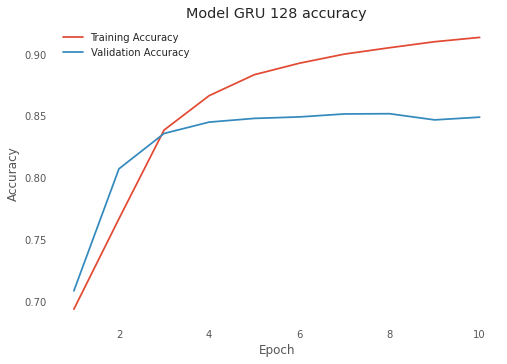

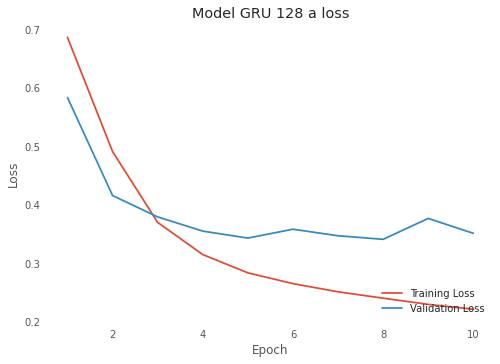

In [27]:
#### Plot training & validation accuracy values
figsize = (25, 12)
plt.style.use("ggplot")
plt.rcParams['axes.facecolor']='white'
epochs = range(1, (len(model9.history.history['acc']) + 1))
plt.plot(epochs,model9.history.history['acc'])
plt.plot(epochs,model9.history.history['val_acc'])
plt.title('Model GRU 128 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

#### Plot training & validation loss values
plt.plot(epochs,model9.history.history['loss'])
plt.plot(epochs,model9.history.history['val_loss'])
plt.title('Model GRU 128 a loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
plt.show()

In [40]:
##### In terms of training time our GRU model was wat faster than the LSTM model and it was similar 
#### to the  the firstSimpleRNN layer with 5 neurons¶
#### total training time was :56.74 really fast
##### This is because  GRU has two gates (reset and update gate).
##### Compare to LSTM that has three gates (input, output and forget gate)
##### GRU use less training parameters and therefore use less memory, execute faster and train faster

In [30]:
print("Training Accuracy GRU 128 is: ",format(history9.history['acc'][-1],".2f"))




print("Validation Accuracy GRU 128 is: ",format(history9.history['val_acc'][-1],".2f"))





print("Training loss GRU 128 is: ",format(history9.history['loss'][-1],".2f"))





print("Validation loss GRU 128 is: ",format(history9.history['val_loss'][-1],".2f"))





score9 = model9.evaluate(x_test,y_test)




print("loss in test set:", score9[0]*100)




print("Accuracy in test set:", score9[1]*100)

Training Accuracy GRU 128 is:  0.91
Validation Accuracy GRU 128 is:  0.85
Training loss GRU 128 is:  0.22
Validation loss GRU 128 is:  0.35
782/782 [==============================] - 3s 4ms/step - loss: 0.3697 - acc: 0.8403 - precision: 0.8613 - recall: 0.8113
loss in test set: 36.97490096092224
Accuracy in test set: 84.03199911117554


##### GRU Model with sequences of length 80 did improve our Accuracy in test set to 84.03 outperforming all previous models
#### Training time decreased compared to LSTM model and lower than RNN models of with 5 neurons and max lenght 30

In [31]:
##### Bonus architecture Bidirectional-gru with sequences of max length 80

In [32]:
tf.debugging.set_log_device_placement(True)
gpus = tf.config.list_logical_devices('GPU')
strategy = tf.distribute.MirroredStrategy(gpus)
with strategy.scope():
    def BidirectionalGRU_128():
        model = Sequential()
        model.add(Embedding(max_features_words, 50, input_shape=(x_train.shape[1],))) 
        model.add(Bidirectional(GRU(128, return_sequences=False)))
        model.add(Dropout(0.5))
        model.add(Dense(1, activation='sigmoid')) ##### Dense 1 == output class
        model.summary()
        return model



model10 = BidirectionalGRU_128()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 80, 50)            1000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               138240    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 1,138,497
Trainable params: 1,138,497
Non-trainable params: 0
_________________________________________________________________


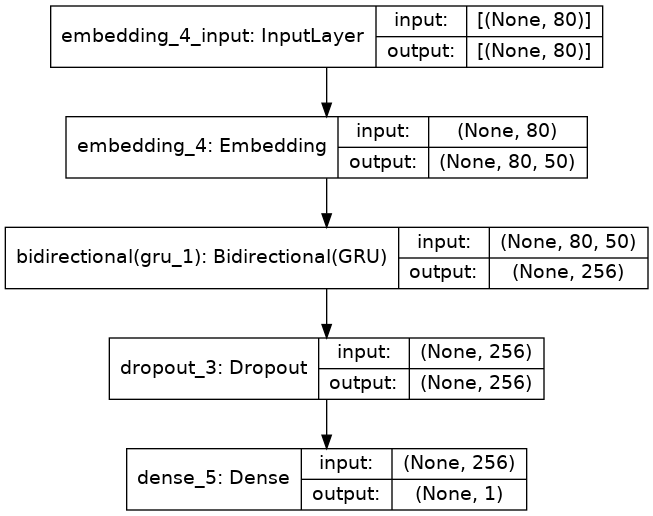

In [33]:
from tensorflow.keras.utils import plot_model
#plot the RNNlstm model architecture

plot_model(model10, to_file='BidirectionalGRU_model_plot.png', show_shapes=True, show_layer_names=True)

In [34]:
##### Compile model Bidirectional  GRU

model10.compile(optimizer = optimizers.RMSprop(lr = .0001), 
             loss='binary_crossentropy',
              metrics=METRICS )

model10.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 80, 50)            1000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               138240    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 1,138,497
Trainable params: 1,138,497
Non-trainable params: 0
_________________________________________________________________


In [35]:
import time

start = time.time()

# train model
history10 = model10.fit(x_train, y_train,
                    epochs=10,
                    validation_split=0.2)

end = time.time()

print(end - start)

Epoch 1/10
625/625 [==============================] - 11s 14ms/step - loss: 0.6910 - acc: 0.7615 - precision: 0.7715 - recall: 0.7462 - val_loss: 0.5819 - val_acc: 0.7022 - val_precision: 0.7277 - val_recall: 0.6343
Epoch 2/10
625/625 [==============================] - 8s 13ms/step - loss: 0.5294 - acc: 0.7378 - precision: 0.7300 - recall: 0.7419 - val_loss: 0.4240 - val_acc: 0.8028 - val_precision: 0.7772 - val_recall: 0.8420
Epoch 3/10
625/625 [==============================] - 8s 13ms/step - loss: 0.3841 - acc: 0.8356 - precision: 0.8343 - recall: 0.8417 - val_loss: 0.3697 - val_acc: 0.8330 - val_precision: 0.8164 - val_recall: 0.8538
Epoch 4/10
625/625 [==============================] - 8s 13ms/step - loss: 0.3193 - acc: 0.8669 - precision: 0.8655 - recall: 0.8676 - val_loss: 0.3535 - val_acc: 0.8402 - val_precision: 0.8187 - val_recall: 0.8688
Epoch 5/10
625/625 [==============================] - 8s 13ms/step - loss: 0.2797 - acc: 0.8850 - precision: 0.8830 - recall: 0.8880 - val_

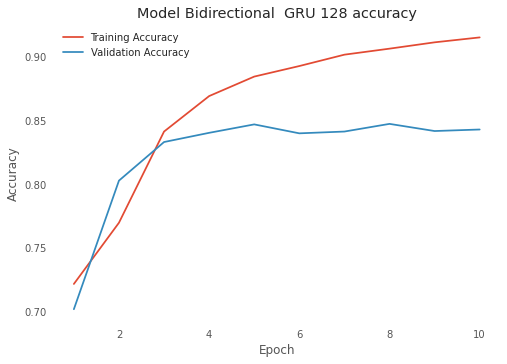

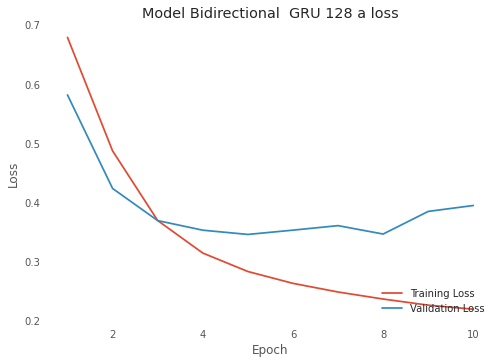

In [36]:
#### Plot training & validation accuracy values
figsize = (25, 12)
plt.style.use("ggplot")
plt.rcParams['axes.facecolor']='white'
epochs = range(1, (len(model10.history.history['acc']) + 1))
plt.plot(epochs,model10.history.history['acc'])
plt.plot(epochs,model10.history.history['val_acc'])
plt.title('Model Bidirectional  GRU 128 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

#### Plot training & validation loss values
plt.plot(epochs,model10.history.history['loss'])
plt.plot(epochs,model10.history.history['val_loss'])
plt.title('Model Bidirectional  GRU 128 a loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
plt.show()

In [37]:
##### In terms of training time our Bidirectional GRU model was a little bit slower than previous GRU because of the
##### Bidirectional nature here one GRU moves forward, beginning from the start of the data sequence,
#### and the other, moves backward, beginning from the end of the data sequence. 
#### total training time was :81.88

In [38]:
print("Training Accuracy Bidirectional GRU  128 is: ",format(history10.history['acc'][-1],".2f"))




print("Validation Accuracy Bidirectional GRU  128 is: ",format(history10.history['val_acc'][-1],".2f"))





print("Training loss Bidirectional GRU  128 is: ",format(history10.history['loss'][-1],".2f"))





print("Validation loss Bidirectional GRU  128 is: ",format(history10.history['val_loss'][-1],".2f"))





score10 = model10.evaluate(x_test,y_test)




print("loss in test set:", score10[0]*100)




print("Accuracy in test set:", score10[1]*100)

Training Accuracy Bidirectional GRU  128 is:  0.91
Validation Accuracy Bidirectional GRU  128 is:  0.84
Training loss Bidirectional GRU  128 is:  0.22
Validation loss Bidirectional GRU  128 is:  0.40
782/782 [==============================] - 4s 5ms/step - loss: 0.4109 - acc: 0.8362 - precision: 0.8142 - recall: 0.8713
loss in test set: 41.09228253364563
Accuracy in test set: 83.61999988555908


In [39]:
##### Bidirectional GRU Model with sequences of length 80 did not improve our Accuracy of previous GRU Model
##### in test set obtaining an acc of 83.61 pretty close 84.03 of previous GRU model
#### Training time increased compared to previous GRU model

###### Final conclusion

##### GRU and LSTM model outperformed in terms of accuracy on test set the simple and tune RNN's model of either max lenght 30 or 80 
##### our GRU Model with sequences of length 80 obtained an Accuracy in test set to 84.03 outperforming all previous models
##### vs Tune RNN (maxlen=80) 78.37 vs 77.12 (simple rnn 5 neurons maxlen=30)
##### In terms of training time with GPU runtine GRU also outperform previous models
##### GRU use less training parameters than LSTM and therefore use less memory, execute faster and train faster
##### This is because  GRU has two gates (reset and update gate).
##### Compare to LSTM that has three gates (input, output and forget gate)
##### Also the using max lenght of 80 worked better for most of the models
##### GRU LSTMs can overcome vanishing and exploding gradients vs RNNs.
